## Boilerplate

In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import copy
from datetime import datetime
import sys
from pathlib import Path
from pprint import pprint
import warnings
import pickle

import json

from tqdm import tqdm
import pickle

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from pymatgen.core.structure import Molecule
# from pymatgen.io.feff.sets import MPXANESSet
from ase import Atom, Atoms
import dscribe
from scipy.interpolate import InterpolatedUnivariateSpline

Some simple `json` utilities...

In [3]:
def read_json(path):
    with open(path, 'r') as infile:
        dat = json.load(infile)
    return dat

def save_json(d, path, indent=4, sort_keys=True):
    """Saves a json file to the path specified.

    Parameters
    ----------
    d : dict
        Must be serializable.
    path : str
        File path to save at.
    """

    with open(path, 'w') as outfile:
        json.dump(d, outfile, indent=indent, sort_keys=sort_keys)

Custom plotting code... ignore this if you don't know what it is!

In [4]:
class NullClass:
    def do_nothing(*args, **kwargs):
        pass
    def add_colorbar(self, im, **kwargs):
        return plt.colorbar(im)
    def __getattr__(self, _):
        return self.do_nothing
try:
    from mpl_utils import MPLAdjutant
    adj = MPLAdjutant()
    adj.set_defaults()
except ImportError:
    adj = NullClass()

# Introduction

This notebook contains preparation scripts for the QM9 data.

# Parse the original QM9 data and construct the FEFF input files

We have a few utilities for the user to more easily load data directly from the QM9 database, as well as to write the appropriate FEFF input files.

In [5]:
from py.utils import read_qm9_xyz, FeffWriter

We cache the loaded results in a `json` file, since they can take a while to reconstruct. You'll have to do this once.

In [6]:
target = Path("raw_qm9.json")
root_dsgdb9nsd = Path("/Users/mc/Data/00_XAS/QM9/QM9_round_1/QM9/dsgdb9nsd")
print("Target exists:", target.exists())

Target exists: True


In [7]:
if target.exists():
    data = read_json(target)
else:
    data = dict()
    paths = list(root_dsgdb9nsd.iterdir())
    for file in tqdm(paths):
        if "dsgdb9nsd" not in str(file):
            continue
        d = read_qm9_xyz(file)
        molecule = Molecule.from_file(file)
        qm9id = d.pop("qm9id")
        d.pop("xyz")
        d.pop("elements")
        d["molecule"] = molecule.as_dict()
        data[qm9id] = d
    save_json(data, target, sort_keys=False)

Initialize a `Molecule` object from the serialized version read from disk (or that was just computed).

In [ ]:
molecules = {key: Molecule.from_dict(xx["molecule"]) for key, xx in data.items()}

Write the FEFF input files to disk. If desired, you can also write EXAFS input files, though for this work we focus on XANES.

In [ ]:
absorbers = ["C", "N", "O"]
spec_type = "XANES"
xanes = True

spec_type = "XANES" if xanes else "EXAFS"
for qm9id, molecule in tqdm(molecules.items()):
    for absorber in absorbers:
        f = FeffWriter(molecule, xanes=xanes, name=qm9id)
        if absorber not in f.elements:
            continue
        dname = Path(f"{absorber}-{spec_type}") / Path(f"{int(qm9id):06}")
        f.write_feff_inputs(str(dname), absorber=absorber)

At this point, you'll want to run the FEFF calculations for all spectra. We share this data and the corresponding ACSF vectors, but do not host the QM9 data ourselves, as it is freely available from http://quantum-machine.org/.

# Package the FEFF results

Once the FEFF jobs are all finished, and it is validated that all completed successfully, we package them into `pickle` files for fast loading. This is done by augmenting the existing `data` dictionary, which already contains all of the QM9 structural information.

In [31]:
from py.utils import load_completed_FEFF_results

## Detour: find the jobs that never started...


In [20]:
paths = Path("C-XANES").rglob("feff.inp")

In [21]:
to_remove = []
for p in tqdm(paths):
    splitted = str(p.parent).split("/")
    if len(splitted) == 2:
        to_remove.append(str(p.parent))

847993it [04:11, 3372.53it/s]


In [25]:
feff_inp_files = Path("C-XANES").rglob("feff.inp")
feff_inp_files = [xx.parent for xx in feff_inp_files]

In [26]:
feff_out_files = Path("C-XANES").rglob("feff.out")
feff_out_files = [xx.parent for xx in feff_out_files]

In [27]:
todo = set(feff_inp_files) - set(feff_out_files)

In [28]:
todo = list(todo)

In [42]:
todo[0]

PosixPath('C-XANES/082111/82111_C_002')

In [43]:
import shutil

In [52]:
for path in todo:
    new_path = Path("C-XANES-todo") / Path("/".join(path.parts[1:]))
    shutil.copytree(path, new_path)

## Process

In [30]:
data = pickle.load(open("XANES-220423-O-N.pkl", "rb"))

In [33]:
absorbers = ["C", "N", "O"]
spec_type = "XANES"

for absorber in absorbers:
    feff_inp_files = Path(f"{absorber}-{spec_type}").rglob("feff.inp")
    failures = []
    total = 0

    for ii, path in enumerate(tqdm(feff_inp_files)):
        data_dict = load_completed_FEFF_results(path.parent)
        qm9_id = data_dict.pop("qm9id")
        site = data_dict.pop("site")
        absorbing_atom = data_dict.pop("absorbing_atom")
        key = f"{site}_{absorbing_atom}"

        if "xanes" not in data[qm9_id].keys():
            data[qm9_id]["xanes"] = dict()

        data[qm9_id]["xanes"][key] = data_dict

        if data_dict["spectrum"] is None:
            failures.append(path.parent)
            continue

        total += 1
            
    # Sometimes FEFF fails to converge. We will ignore these cases later.
    print(f"For absorber {absorber} we note {len(failures)} failures out of {total} total")

846557it [2:40:49, 87.73it/s] 

For absorber C we note 3983 failures out of 842574 total


Save the data to the `pickle` file. This will prove extremely useful for loading in later and constructing the ACSF vectors.

In [34]:
today = datetime.now().strftime("%y%m%d")
save_string = f"XANES-{today}-C-N-O.pkl"

In [ ]:
pickle.dump(data, open(save_string, "wb"), protocol=4)

# Construct the ACSF feature vectors

In [6]:
from dscribe.descriptors import ACSF

In [7]:
target = Path("XANES-220621-C-N-O.pkl")
print(target.exists())
data = pickle.load(open(target, "rb"))

True


EOFError: Ran out of input

In [ ]:
grids = {"O": np.linspace(528, 582, 200)}

In [ ]:
print(len(data))

In [13]:
species = ["H", "C", "O", "N", "F"]
rcut = 6.0
g2_params = [[1.0, 0], [0.1, 0], [0.01, 0]]
g4_params=[
    [0.001, 1.0, -1.0],
    [0.001, 2.0, -1.0],
    [0.001, 4.0, -1.0],
    [0.01, 1.0, -1.0],
    [0.01, 2.0, -1.0],
    [0.01, 4.0, -1.0],
    [0.1, 1.0, -1.0],
    [0.1, 2.0, -1.0],
    [0.1, 3.0, -1.0]
]
central_atom = "O"
grid = grids[central_atom]

acsf = ACSF(
    species=species,
    rcut=rcut,
    g2_params=g2_params,
    g4_params=g4_params
)

In [23]:
molecule_site_pairs = []
acsf_array = []
spectra = []

# cc = 0
for qm9id, datum in tqdm(data.items()):
    molecule = Molecule.from_dict(datum["molecule"])
    atoms = []
    central_atom_indexes = []
    for ii, site in enumerate(molecule):
        atom = Atom(site.specie.symbol, site.coords)
        atoms.append(atom)
        if site.specie.symbol == central_atom:
            central_atom_indexes.append(ii)
    atoms = Atoms(atoms)
    
    if len(central_atom_indexes) == 0:
        continue

    tmp_acsf = acsf.create(atoms, positions=central_atom_indexes)
    
    for idx, ii in enumerate(central_atom_indexes):
        key = f"{ii}_{central_atom}"
        s = np.array(datum["xanes"][key]["spectrum"])

        try:
            spline = InterpolatedUnivariateSpline(s[:, 0], s[:, 3])
        except IndexError:
            continue
            
        res = spline(grid)
        
        # Oxygen screening condition for unphysical results
        if central_atom == "O":
            if np.any(res[:10] > 5.0):
                continue
        
        spectra.append(res)
        acsf_array.append(tmp_acsf[idx])
        molecule_site_pairs.append(f"{qm9id}_{ii}")
        
    
#     if cc == 10:
#         break
#     cc += 1

acsf_array = np.array(acsf_array)
spectra = np.array(spectra)

100%|████████████████████████████████████████████████████████████████████████| 133885/133885 [06:02<00:00, 369.73it/s]


In [24]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [26]:
pca_acsf = PCA(2)
w_acsf = pca_acsf.fit_transform(acsf_array)

In [27]:
pca_spectra = PCA(2)
w_spectra = pca_spectra.fit_transform(spectra)

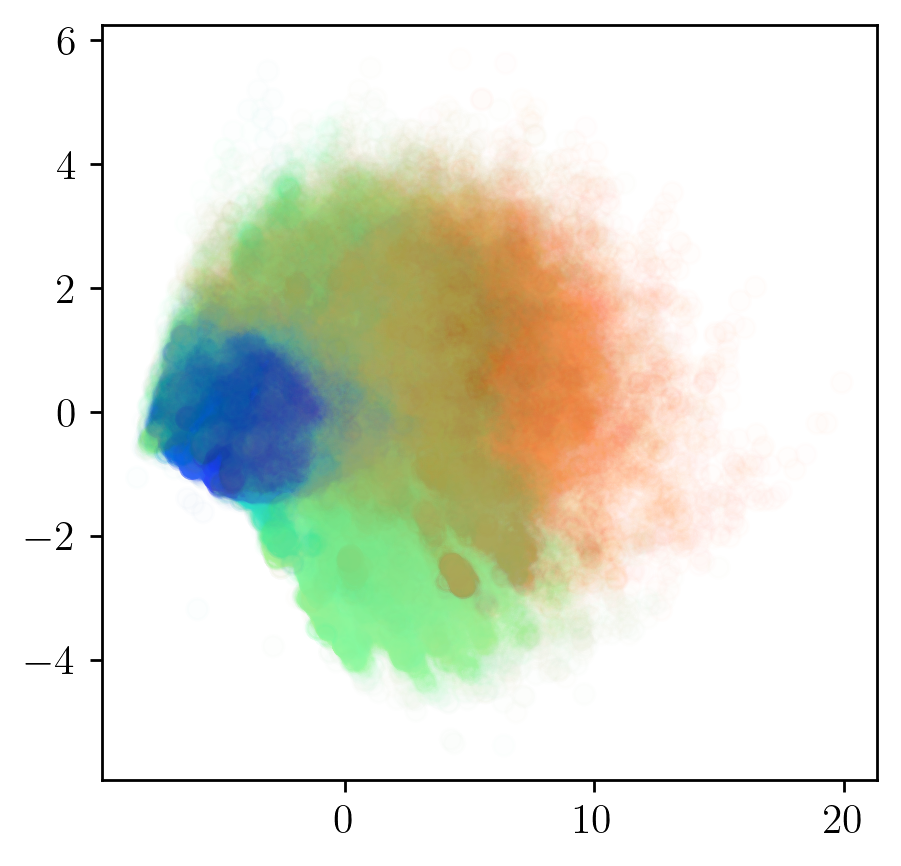

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.scatter(w_acsf[:, 0], w_acsf[:, 1], alpha=0.01, c=w_spectra[:, 0], cmap="rainbow")

plt.show()

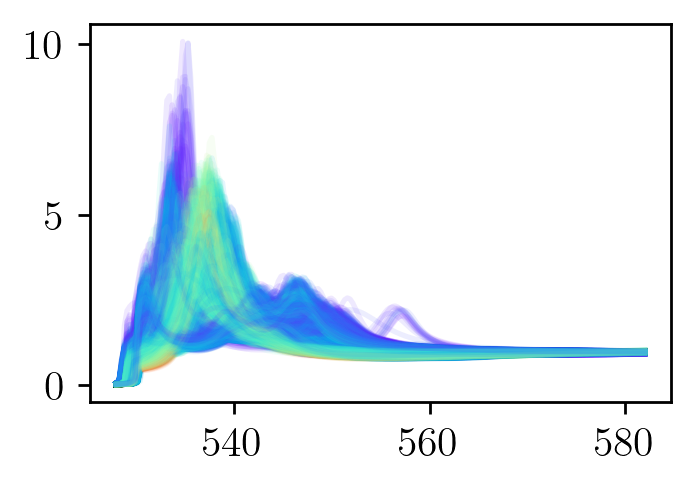

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))

N = 10
M = 100

dig = np.digitize(w_acsf[::N, 0], bins=np.linspace(w_acsf[::N, 0].min(), w_acsf[::N, 0].max(), M))
cmap = cm.get_cmap("rainbow", M)

for ii, (spectrum, col, key) in enumerate(zip(spectra[::N], w_spectra[::N, 0], molecule_site_pairs[::N])):
    ax.plot(grid, spectrum, color=cmap(dig[ii]), alpha=0.1)

plt.show()

In [ ]:
# rcut = 6.0
# nmax = 8
# lmax = 6
# central_atom = "O"

In [39]:
fname = f"XANES-220531-data-{central_atom}-ACSF.pkl"
print(fname)

XANES-220531-data-O-ACSF.pkl


In [40]:
pickle.dump({"grid": grid, "y": spectra, "x": acsf_array}, open(fname, "wb"), protocol=4)